## Perceptron vs Neural Networks

## Question 2. Neural Network’s Decision Boundary

### I. Load Datasets and Plot Them

I load the `Task2B train.csv` and `Task2B test.csv` datasets, then using the function `plot_scatter_by_label`, I plot them separately with different colors for different labels.

In [19]:
import pandas as pd 
import numpy as np

# Load training and test datasets
train_df = pd.read_csv('Task2B_train.csv')
test_df = pd.read_csv('Task2B_test.csv')

# Inspect the data
print(train_df.head())
print(test_df.head())

   feature1  feature2  label
0 -0.612143  4.068064      0
1 -0.922175  1.731439      0
2 -0.940942  2.154830      0
3  0.346952  1.024161      0
4  0.670974 -0.132000      0
   feature1  feature2  label
0  0.336603  1.157933      0
1 -0.990020  2.083285      0
2 -1.186954  3.465390      0
3 -1.327837  5.062712      0
4 -0.870706  4.634610      0


In [2]:
import matplotlib.pyplot as plt

def plot_scatter_by_label(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.set_figheight(6)
        fig.set_figwidth(8)
    categories = np.unique(y)
    for cat in categories:
        ax.scatter(X[y==cat, 0], X[y==cat, 1], label='Cluster {0}'.format(cat), alpha=0.25)
    ax.set_xlabel('feature 1', size=15)
    ax.set_ylabel('feature 2', size=15)
    ax.set_title(title if title else "Gaussian Mixture", size=20)
    ax.grid()
    plt.legend()
    return ax

<Axes: title={'center': 'Test Dataset'}, xlabel='feature 1', ylabel='feature 2'>

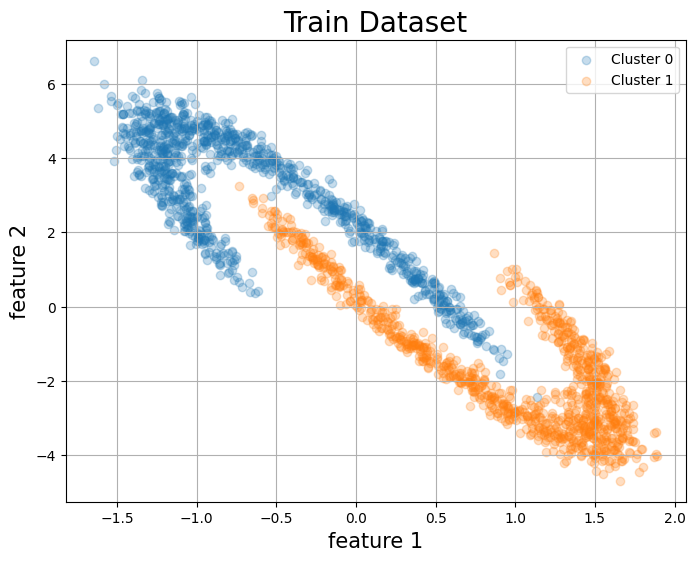

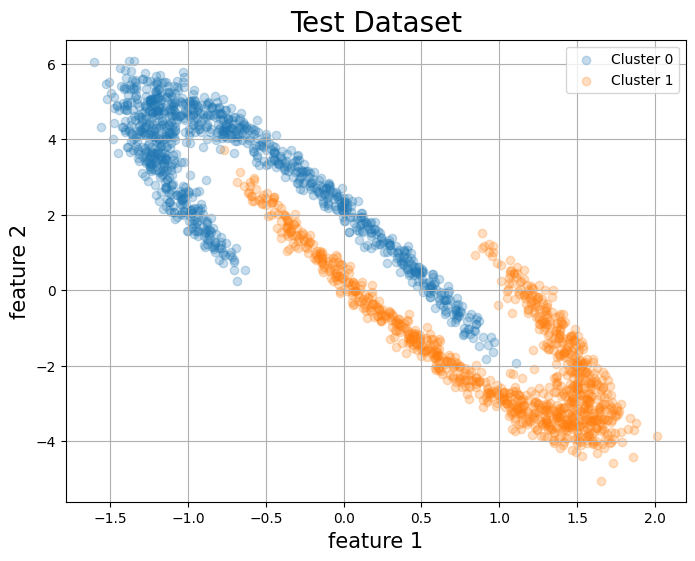

In [3]:
# Plot the training and testing dataset separately

X_train = train_df[['feature1', 'feature2']].values
X_test = test_df[['feature1', 'feature2']].values
y_train = train_df['label'].values
y_test = test_df['label'].values

plot_scatter_by_label(X=X_train, y=y_train, title = "Train Dataset")
plot_scatter_by_label(X=X_test, y=y_test, title = "Test Dataset")

### II. Train Perceptron Models


The perceptron is a binary linear classifier that maps an input vector $ \mathbf{x} \in \mathbb{R}^d $ to an output label $ y \in \{0, 1\} $ using a linear decision boundary.

Perceptron assumes linearly separable data and uses a modified step function as activation function, which is not differentiable, thus it cannot use gradient-based learning. The class prediction rule is given by

$$
\boldsymbol{\hat{y}(x,w)} = \begin{cases}
1 & \text{if } \mathbf{w}^\top \mathbf{x} \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$
with 
- $ \mathbf{w} $: weight vector  
- $ b $: bias (threshold)

Since it cannot use gradient-based algorithm for the optimization, whenever there is a misclassification, it updates weights using the following rule:

$$
\mathbf{w} \leftarrow \mathbf{w} + (2t_n - 1) \eta \mathbf{x_n}
$$

for each training data point $(\mathbf{x_n}, t_n)$ randomly ordered. Where $\eta > 0$ is the learning rate. The formula $2t_n - 1$ is another way to write the case distinction below, so that the code is more efficient.
$$
\mathbf{w} \leftarrow
\begin{cases}
\mathbf{w} + \eta \mathbf{x_n} &, \text{ if } t_n = 1\\
\mathbf{w} - \eta \mathbf{x_n} &, \text{ if } t_n = 0
\end{cases} \\
$$

In the implementation below, I implement the `Perceptron` class

In [4]:
class Perceptron:
    
    def __init__(self, eta=0.01, tau_max=10000, epsilon=0.005, random_state=None):
        self.eta = eta   # learning rate
        self.tau_max = tau_max   # max number of iterations
        self.epsilon = epsilon   # tolerable error
        self.random_state = random_state

    def fit(self, x, y):
        RNG = np.random.default_rng(self.random_state)
        n, p = x.shape  

        self.w_trace_ = np.empty((self.tau_max, p))     # trace of weights during training
        self.xy_idx_trace_ = np.empty(self.tau_max, int) # trace of considered training point indices
        
        # initialisation of iteration counter and weights
        tau = 0 
        self.w_ = self.w_trace_[0,:] = RNG.normal(size=p) 
        terminate = False
        while not (terminate or (self.predict(x)!=y).mean()<self.epsilon):
            # random order to consider training data
            order = RNG.choice(np.arange(n),size = n ,replace = False)
            for i in range(n):
                if self.predict(x[order][i]) != y[order][i]:
                    self.w_ = self.w_ + (2*y[order][i]-1)*self.eta * x[order][i]
                
                self.w_trace_[tau+1] = self.w_
                self.xy_idx_trace_[tau] = order[i]

                tau +=1
                if tau == self.tau_max-1:
                    terminate = True
                    break
        
        # remove empty rows from traces
        self.w_trace_ = self.w_trace_[:tau] 
        self.xy_idx_trace_ = self.xy_idx_trace_[:tau-1]

        return self

    def predict(self, x):
        return (x.dot(self.w_) >= 0).astype(int)


To train the perceptron, I use the affine perceptron, adding a bias term so that the resulting decision boundary can be shifted from the origin. The class prediction rule becomes

$$
\boldsymbol{\hat{y}(x,w)} = \begin{cases}
1 & \text{if } \mathbf{w}^\top \mathbf{x} + b \geq 0 \\
0 & \text{otherwise}
\end{cases}
$$

To implement the bias in code, I use `PolynomialFeatures` with order 1 and `make_pippeline`, adding a constant 1-term to the input vector. I train two models of perceptron, one with learning rate $\eta = 0.1$ and the other with $\eta=1.0$. From these two models, I compute the test errors and compare them to obtain the best learning rate.

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import zero_one_loss

etas = [0.1,1.0]
epochs = 100
rand_state = 3

train_errors = {eta: [] for eta in etas}
test_errors = {eta: [] for eta in etas}
avg_test_errors = {eta: [] for eta in etas}
weights = {eta: [] for eta in etas}

for i in range(epochs):
    for eta in etas:
        model = make_pipeline(
            PolynomialFeatures(1), 
            Perceptron(eta = eta, random_state=rand_state))
        model.fit(X_train, y_train)
        train_errors[eta].append(zero_one_loss(model.predict(X_train), y_train))
        test_errors[eta].append(zero_one_loss(model.predict(X_test), y_test))
        weights[eta].append(model[1].w_)
      
for eta in etas:
    avg_test_errors[eta] = np.mean(test_errors[eta])
    print(f"eta = {eta:.1f} | Avg Test Error: {avg_test_errors[eta]:.4f}")

if avg_test_errors[etas[0]] < avg_test_errors[etas[1]]:
    best_weight = np.mean(weights[etas[0]],axis=0)
    best_eta = etas[0]
else:
    best_weight = np.mean(weights[etas[1]],axis=0)
    best_eta = etas[1]

print(f"\nBest eta = {best_eta:.1f}")


eta = 0.1 | Avg Test Error: 0.1250
eta = 1.0 | Avg Test Error: 0.1260

Best eta = 0.1


While training these two models I realized that perceptron is quite sensitive to randomness of training data points. In an attempt to fix this, I tried to run the training multiple times then average the testing errors and the weight vectors to find the best eta and plot the decision boundary. However, even with that attempt, if I didn't set the `random_state`, then the result of the `best_eta` will just keep switching between the learning rates. It might also be the sensitivity of the algorithm to local minima (solution gets stuck in a local minima).

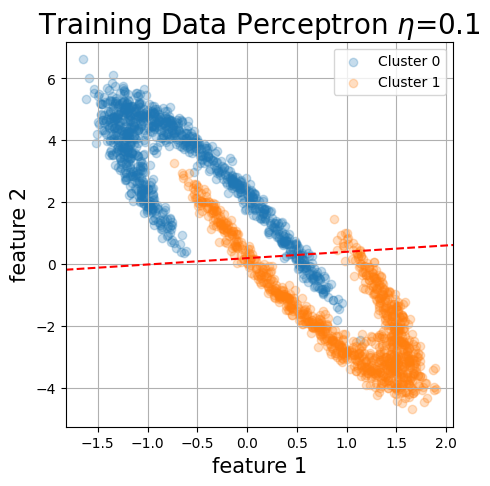

In [17]:
def plot_line(slope, intercept, ax=None, shape='--', **kwargs):
    ax = plt.gca() if ax is None else ax
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.set_ylim(ax.get_ylim())
    ax.set_xlim(ax.get_xlim())
    ax.plot(x_vals, y_vals, shape, **kwargs)

def plot_decision_boundary_from_weights_with_intercept(w, ax=None):
    slope = -w[1]/w[2]
    intercept = -w[0]/w[2]
    plot_line(slope, intercept, ax, shape='--', color='red')

fig, ax = plt.subplots(figsize=(5, 5))
plot_scatter_by_label(X_train, y_train, ax=ax, title = rf"Training Data Perceptron $\eta$={best_eta}")
plot_decision_boundary_from_weights_with_intercept(best_weight)

plt.show()

As I have mentioned above, the decision boundary in this plot is a result of averaging 100 runs of weight vectors. Though it is not passing the origin anymore due to the bias term, the linear decision boundary is still not enough to completely separate the two clusters as expected. 

### III. Train 3-Layer Neural Network

#### Neural Network

Since the perceptron is not giving a satisfactory result, we want to try training a 3-layer neural network to work on this binary classification task. In a neural network, there are multiple *neurons*, which will be called unit in the later part of the document. Neuron is a computational unit that takes input $\mathbf{x}\coloneqq (x_1,x_2, \ldots, x_N)$ and a +1 intercept (bias) term, then outputs activations, which is given by
$$h_{\mathbf{W},b} \coloneqq f(\mathbf{W}^\top x) = f(\sum_{i=1}^N W_i x_i + b)$$
with $w$ as the parameter or weight, and $b$ as the bias term. 

In neural network, we will see how a collection of these neurons work together to process the input into predicting an output. The *3-layer* are consist of the input layer, one hidden layer, and the output layer. In our problem, we have two input units (equivalent to two neurons) and one output unit. For the hidden units, we will see how the number of hidden units affect the performance of the network. Additionally, similar to the perceptron training in the previous section, we will also see the effect of different learning rates. 

#### Activation Functions
First I set the *activation or auxiliary functions*, which are the $f(\cdot)$ in the above equation. I use **Rectified Linear Unit (ReLU)** with the following function for the hidden layer activation.
$$\mathrm{ReLU}(z) = \max(0, z)$$

It has a derivative as follows 

  $$\mathrm{ReLU}'(z) = \mathbb{I}\{z > 0\} = 
  \begin{cases}
    1 & \text{if } z > 0 \\
    0 & \text{otherwise}
  \end{cases}$$

Although binary classification usually use the sigmoid function as the activation function, ReLU is computationally simpler and helps with the vanishing gradient problem that sigmoid can suffer from. 

For the output layer activation, I use the **sigmoid function** with the following funtion
$$\sigma(z) = \frac{1}{1+ \text{exp}(-z)}$$

The derivative of the sigmoid function is given by

$$ \sigma'(z) = \sigma(z) (1-\sigma(z))$$

Let $\boldsymbol\theta$ denote the collection of all model parameters: weights and biases of the network. We use $h_{\boldsymbol\theta}(\mathbf{x})$ to denote the prediction (output activation) of the network given input $\mathbf{x}$. The objective of this training is to minimize a *binary cross-entropy* error function

$$E(\boldsymbol\theta) = -\frac{1}{N} \sum_{n=1}^{N} \left[ y^{(n)} \log h_{\boldsymbol\theta}(\boldsymbol x^{(n)}) + (1 - y^{(n)}) \log (1 - h_{\boldsymbol\theta}(\boldsymbol x^{(n)})) \right]$$

where :
- $h_{\boldsymbol\theta}$ ≈ 1 when y = 1
- $h_{\boldsymbol\theta}$ ≈ 0 when y = 0

#### Forward Propagation

In forward propagation, we compute the activations through the network layers:

Given:

* Input $\mathbf{X} \in \mathbb{R}^{N \times D}$, where $N$ is the number of samples and $D$ is the input dimension.
* Weights $\mathbf{W}^{[1]} \in \mathbb{R}^{D \times K}$, biases $\mathbf{b}^{[1]} \in \mathbb{R}^{1 \times K}$ from input to hidden layer.
* Weights $\mathbf{W}^{[2]} \in \mathbb{R}^{K \times 1}$, biases $\mathbf{b}^{[2]} \in \mathbb{R}^{1 \times 1}$ from hidden to output layer.

1. Compute the hidden layer input:
   $$
   \mathbf{z}^{[2]} = \mathbf{X} \mathbf{W}^{[1]} + \mathbf{b}^{[1]}
   $$

2. Apply ReLU activation:
   $$
   \mathbf{a}^{[2]} = \mathrm{ReLU}(\mathbf{z}^{[2]})
   $$

3. Compute the output layer input:
   $$
   \mathbf{z}^{[3]} = \mathbf{a}^{[2]} \mathbf{W}^{[2]} + \mathbf{b}^{[2]}
   $$

4. Apply sigmoid activation to produce final output:
   $$
   h_{\boldsymbol\theta} = \sigma(\mathbf{z}^{[3]})
   $$

The final prediction $h_{\boldsymbol\theta}$ gives the probability of class 1 for each input.

#### Backpropagation and Gradient Computation

To minimize the binary cross-entropy error, we compute the gradients of the loss with respect to all parameters using the chain rule.

Let:

- $\delta^{[3]} = h_{\boldsymbol\theta} - \mathbf{y}$: error at output layer
- $\delta^{[2]} = (\delta^{[3]} \mathbf{W}^{[2]^\top}) \circ \mathrm{ReLU}'(\mathbf{z}^{[2]})$: error at hidden layer

Then the gradients of the loss are:

- $\frac{\partial E}{\partial \mathbf{W}^{[2]}} = \frac{1}{N} \mathbf{a}^{[2]^\top} \delta^{[3]} + \alpha \mathbf{W}^{[2]}$
- $\frac{\partial E}{\partial \mathbf{b}^{[2]}} = \frac{1}{N} \sum \delta^{[3]}$
- $\frac{\partial E}{\partial \mathbf{W}^{[1]}} = \frac{1}{N} \mathbf{X}^\top \delta^{[2]} + \alpha \mathbf{W}^{[1]}$
- $\frac{\partial E}{\partial \mathbf{b}^{[1]}} = \frac{1}{N} \sum \delta^{[2]}$

with $\alpha$ is the L2 regularization term. These gradients are then used to update the parameters.

#### Parameter Update

For each epoch, we update the weights and biases using gradient descent:

- $\mathbf{W}^{[l]} := \mathbf{W}^{[l]} - \eta \cdot \frac{\partial E}{\partial \mathbf{W}^{[l]}}$ 
- $\mathbf{b}^{[l]} := \mathbf{b}^{[l]} - \eta \cdot \frac{\partial E}{\partial \mathbf{b}^{[l]}}$

where $l \in \{1, 2\}$ denotes the layer number, and $\eta$ is the learning rate. This completes one epoch of training. By iterating this process over multiple epochs, the neural network parameters are optimized to minimize the binary cross-entropy loss.


In [ ]:
# Decompose the shape of X_train to initialize the parameters
N = X_train.shape[0]
D = X_train.shape[1]

# Reshape the labels
T1 = y_train.reshape(-1, 1)
T2 = y_test.reshape(-1, 1)

N, D

(2000, 2)

In [81]:
class NeuralNetwork:
    def __init__(self, D, K, eta=0.01, alpha=0.0001, seed=25, max_epoch = 5000):
        np.random.seed(seed)        # for reproducibility
        self.D = D                  # input dimension (number of features)
        self.K = K                  # number of units in the hidden layer
        self.eta = eta              # learning rate
        self.alpha = alpha          # regularization term
        self.max_epoch = max_epoch  # max number of iteration
        # Weights and biases

        # weight and bias to process from input layer to hidden layer
        self.W1 = np.random.normal(scale=0.5, size=(self.D, self.K))
        self.b1 = np.zeros((1, self.K))

        # weight and bias to process from hidden layer to output layer
        self.W2 = np.random.normal(scale=0.5, size=(self.K, 1))
        self.b2 = np.zeros((1, 1))

    # ----- Activation / auxiliary functions -----
    ## Hidden layer activation: ReLU
    def relu(self, z):
        return np.maximum(0, z)
    
    ## Derivative of ReLU
    def relu_d(self, z):
        return (z > 0).astype(float)
    
    ## Output layer activation: sigmoid
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    ## Derivative of sigmoid
    def sigmoid_d(self, z):
        s = self.sigmoid(z)
        return s * (1 - s)

    # ----- Forward propagation -----
    def feedforward(self, X): # X = a1 is the input vector
        # input layer -> hidden layer 
        self.z2 = X @ self.W1 + self.b1         # compute the total net input z2 for hidden layer
        self.a2 = self.relu(self.z2)            # apply z2 to the activation function to proceed to hidden layer
        # hidden layer -> output layer
        self.z3 = self.a2 @ self.W2 + self.b2   # compute the total net input z3 for output layer
        self.a3 = self.sigmoid(self.z3)         # apply z3 to the activation function to get the output
        return self.a3 # a3 is the output, which is the probability of Cluster 1 

    # Prediction (binary)
    ## Classify points with probability larger than 0.5 to Cluster 1
    ## Thus converting the continuous output into binary class labels
    def predict(self, X):
        probs = self.feedforward(X)
        return (probs >= 0.5).astype(int) 

    # Accuracy
    def accuracy(self, X, y):
        return np.mean(self.predict(X) == y)

    # Backpropagation and parameter update
    def backpropagation(self, X, y):
        N = X.shape[0]
        # output layer error term
        d3 = self.a3 - y     # (N, 1)
        # hidden layer error term 
        d2 = (d3 @ self.W2.T) * self.relu_d(self.z2)      # (N, K)

        # Gradients of the training objective
        # 1st layer: input layer -> hidden layer 
        W1_d = X.T @ d2 / N + self.alpha * self.W1        # (D, K)
        b1_d = np.sum(d2, axis=0, keepdims=True) / N      # (1, K)
        # 2nd layer: hidden layer -> output layer 
        W2_d = self.a2.T @ d3 / N + self.alpha * self.W2  # (K, 1)
        b2_d = np.sum(d3, axis=0, keepdims=True) / N      # (1, 1)

        # Update weights and biases
        self.W1 -= self.eta * W1_d
        self.b1 -= self.eta * b1_d
        self.W2 -= self.eta * W2_d
        self.b2 -= self.eta * b2_d
    
        return self.W1, self.b1, self.W2, self.b2
    
    # Training loop
    def train(self, X, y):
        for epoch in range(self.max_epoch):
            self.feedforward(X)
            model = self.backpropagation(X, y)
        return model
    

In [ ]:
# Train the 3-layer Neural Network for  different combinations of K and eta
results = {}            # to store the result of accuracy and model
K = range(5, 41, 5)
etas = [0.01, 0.001]
for k in K:
    for eta in etas:
        nn = NeuralNetwork(D=D, K=k, eta=eta, seed = 25)
        model = nn.train(X_train, T1)       # get model parameters
        acc = nn.accuracy(X_test, T2)
        results[(k, eta)] = [acc, model]    # store parameters as well to plot the decision boundary based on best model

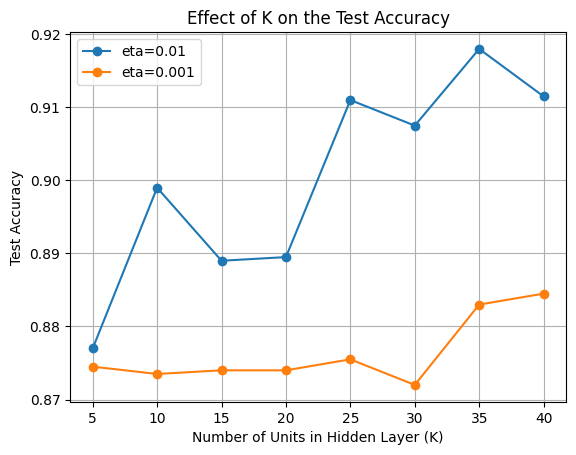

In [ ]:
# Plot the effect of K on the accuracy
for eta in etas:
    accs = [results[(k, eta)][0] for k in K]  # get the accuracies only
    plt.plot(K, accs, marker='o', label=f"eta={eta}")
plt.xlabel("Number of Units in Hidden Layer (K)")
plt.ylabel("Test Accuracy")
plt.title("Effect of K on the Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

From this plot, we can see that higher number of hidden units $K$ leads to higher accuracy in both choices of learning rates on average. Though both curve are not monotonically increasing, there is definitely some upward trend. This result also shows that $\eta = 0.001$ seems to be underfitting compared to $\eta = 0.01$. The larger learning rate shows clear improvement as $K$ increases, unlike the smaller $\eta$ who mostly remains almost flat. Therefore, the best $K$ based on this result is $K=35$, and the best $\eta$ is $0.01$. This result is formalized below, with their corresponding test accurary score. Next I also plot the decision boundary based on the best model with the test data.

In [99]:
# Find the best pair of K and eta with the highest test accuracy
best_pair = max(results, key=lambda k: results[k][0])
best_accuracy = results[best_pair][0]
best_W1, best_b1, best_W2, best_b2 = results[best_pair][1]

print("Best (K, eta) pair:", best_pair)
print("Best accuracy:", best_accuracy)

Best (K, eta) pair: (35, 0.01)
Best accuracy: 0.918


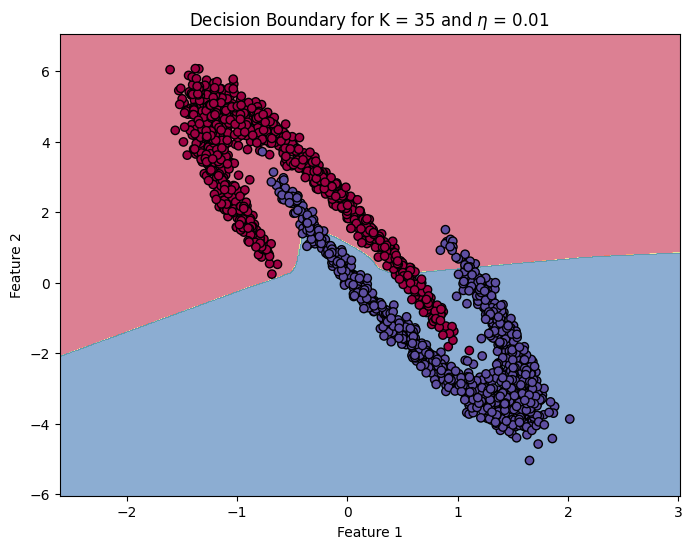

In [85]:
# Plot the best model with the test data

def plot_decision_boundary(model, X, y, title = None):
    # Create a mesh grid over feature space
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    h = 0.01  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict over the entire grid
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid)  # this assumes model has a .predict method
    Z = Z.reshape(xx.shape)

    # Plot contour and training points
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')
    if title == None:
        plt.title("Decision Boundary")
    else:
        plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

model = NeuralNetwork(D=D, K=best_pair[0], eta=best_pair[1], seed=25)

# Assign best weights
model.W1 = best_W1
model.b1 = best_b1
model.W2 = best_W2
model.b2 = best_b2

plot_decision_boundary(model, X_test, y_test, title = fr"Decision Boundary for K = {best_pair[0]} and $\eta$ = {best_pair[1]}")

From the plot we can see that the decision boundary is not aligning well with the separation of the two classes. Though the accuracy was quite high already, this result means it has not fully converged yet. In an attempt to solve this issue, I tried to train the Neural Network with more iteration, `max_epoch = 200000`, using the best pair of $K$ and $\eta$ that I have found.

Accuracy = 0.9985


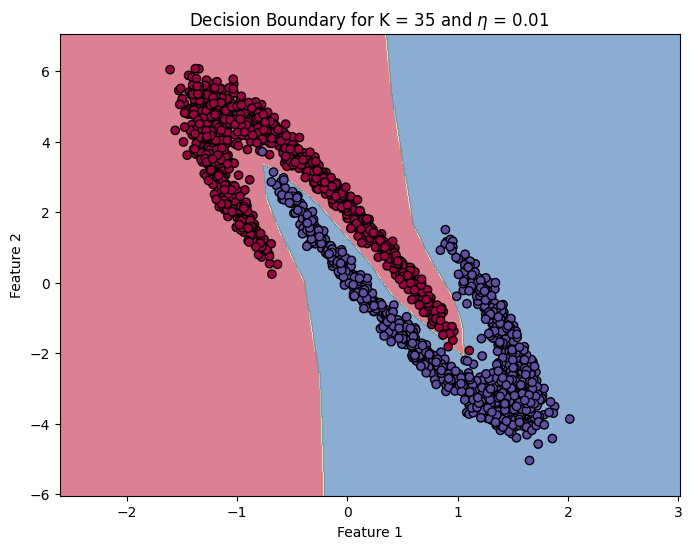

In [94]:
nn1 = NeuralNetwork(D=D, K=best_pair[0], eta=best_pair[1], seed=25, max_epoch= 200000)
nn1.train(X_train, T1)

print(f"Accuracy = {nn1.accuracy(X_test, T2)}")
plot_decision_boundary(nn1, X_test, y_test, title = fr"Decision Boundary for K = {best_pair[0]} and $\eta$ = {best_pair[1]}")

### Analysis & Comparison between Perceptron and 3-Layer Neural Network

From section II and III, it is clear that the perceptron cannot completely separate the two classes due to the distribution of the data. While the 3-Layer Neural Network, successfully separate the two classes even with extreme curved shape of the distribution.

This is might be due to the perceptron algorithm assuming that data is linearly separable, and its decision boundary is defined by the linear combination $w^\top x +b$. Although it applies a non-linear step function, this function is non-differentiable, preventing the use of gradient-based learning.

In contrast, a 3-layer neural network introduces differentiable nonlinearities in the hidden layer via activation functions like ReLU or tanh. This allows the model to approximate non-linear decision boundaries and enables gradient-based optimization (backpropagation). The differentiability of the entire network also allows the output layer's activation function to be matched to the problem in hand (e.g., sigmoid for binary classification or softmax for multiclass classification) making neural networks far more flexible than perceptrons.

### Appendix : Comparison with `MLPClassifier`

I finally got better result with clear separation between the two classes after I increase the maximum iteration, though it took much longer time to run, around five times longer. Additionally, I tried to use the built-in function from `scikit-learn` for multi-layer perceptron, `MLPClassifier` to compare with my manual implementation result. My result is almost similar to the result from `MLPClassifier`, especially with the test accuracy being the exact same to the fourth decimal point, `0.9985`. Thus, it proves that my implementation is not wrong, though it is not as efficient and computationally cheap as the built-in function.

In [88]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Scale the features (important for MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(best_pair[0],), 
                    activation='relu',                   
                    solver='adam',
                    alpha=0.0001,                        
                    learning_rate_init=best_pair[1],     
                    max_iter=5000,
                    random_state=25)

clf.fit(X_train_scaled, y_train)

# Evaluate
y_pred = clf.predict(X_test_scaled)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Test Accuracy: 0.9985


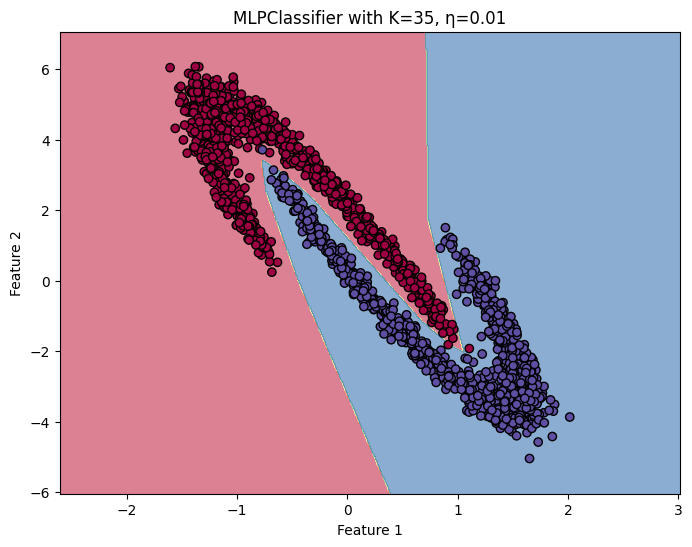

In [87]:
def plot_mlp_decision_boundary(model, X, y, scaler, title=None):
    h = 0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scaled = scaler.transform(grid)
    Z = model.predict(grid_scaled).reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.6)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(title or "MLPClassifier Decision Boundary")
    plt.show()

# Call the plot function
plot_mlp_decision_boundary(clf, X_test, y_test, scaler, title=f"MLPClassifier with K={best_pair[0]}, η={best_pair[1]}")
